In [2]:
import pandas as pd
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('ncaa_mens_scores_2024.csv')

In [4]:
ncaaAvgHomeGoals = df['home_team_score'].mean()
ncaaAvgAwayGoals = df['away_team_score'].mean()

In [5]:
# Cap goal differences at a maximum of 5 goals
df['capped_home_team_score'] = df.apply(
    lambda row: min(row['home_team_score'], row['away_team_score'] + 5), axis=1
)
df['capped_away_team_score'] = df.apply(
    lambda row: min(row['away_team_score'], row['home_team_score'] + 5), axis=1
)

# Create home df
teams = df[df['home_team_conference'] != 'Not D1'][['home_team', 'home_team_conference']].drop_duplicates()
home_df = teams
home_df.columns = ['Team', 'Conference']

# Initialize home df columns using capped scores
home_df['MP'] = home_df['Team'].apply(lambda team: len(df[df['home_team'] == team]))
home_df['GF'] = home_df['Team'].apply(lambda team: df[df['home_team'] == team]['capped_home_team_score'].sum())
home_df['GA'] = home_df['Team'].apply(lambda team: df[df['home_team'] == team]['capped_away_team_score'].sum())

home_df['ATT'] = home_df.apply(
    lambda row: ((row['GF'] / row['MP']) / ncaaAvgHomeGoals) * 
                (df[df['home_team_conference'] == row['Conference']]['capped_home_team_score'].mean() / ncaaAvgHomeGoals),
    axis=1
)

home_df['DEF'] = home_df.apply(
    lambda row: ((row['GA'] / row['MP']) / ncaaAvgAwayGoals) * 
                (df[df['home_team_conference'] == row['Conference']]['capped_away_team_score'].mean() / ncaaAvgAwayGoals),
    axis=1
)

# Create away df
teams_away = df[df['away_team_conference'] != 'Not D1'][['away_team', 'away_team_conference']].drop_duplicates()
away_df = teams_away
away_df.columns = ['Team', 'Conference']

# Initialize away df columns using capped scores
away_df['MP'] = away_df['Team'].apply(lambda team: len(df[df['away_team'] == team]))
away_df['GF'] = away_df['Team'].apply(lambda team: df[df['away_team'] == team]['capped_away_team_score'].sum())
away_df['GA'] = away_df['Team'].apply(lambda team: df[df['away_team'] == team]['capped_home_team_score'].sum())

away_df['ATT'] = away_df.apply(
    lambda row: ((row['GF'] / row['MP']) / ncaaAvgAwayGoals) * 
                (df[df['away_team_conference'] == row['Conference']]['capped_away_team_score'].mean() / ncaaAvgAwayGoals),
    axis=1
)

away_df['DEF'] = away_df.apply(
    lambda row: ((row['GA'] / row['MP']) / ncaaAvgHomeGoals) * 
                (df[df['away_team_conference'] == row['Conference']]['capped_home_team_score'].mean() / ncaaAvgHomeGoals),
    axis=1
)


In [6]:
# Calculate expected scoreline
def calculateExpectedScoreline(home, away):
    # Check if the teams exist in the dataframes
    if home not in home_df['Team'].values or away not in away_df['Team'].values:
        raise ValueError(f"One or both teams ({home}, {away}) not found in the data.")

    # Get the rows for the respective teams
    home_row = home_df[home_df['Team'] == home]
    away_row = away_df[away_df['Team'] == away]
    
    # Extract attack and defense ratings
    home_att = home_row['ATT'].values[0]
    home_def = home_row['DEF'].values[0]
    away_att = away_row['ATT'].values[0]
    away_def = away_row['DEF'].values[0]
    
    # Calculate expected goals for both teams
    home_xG = home_att * away_def * ncaaAvgHomeGoals
    away_xG = away_att * home_def * ncaaAvgAwayGoals
    
    return [home_xG, away_xG]

# Calculate match probabilities
def calculateMatchProbability(home, away, max_goals=10):
    # Get expected goals for the match
    try:
        home_xG, away_xG = calculateExpectedScoreline(home, away)
    except ValueError as e:
        return str(e)

    # Initialize cumulative probabilities
    home_win_prob = 0
    draw_prob = 0
    away_win_prob = 0

    # Iterate through possible scores to compute probabilities
    for home_goals in range(max_goals):
        for away_goals in range(max_goals):
            # Calculate Poisson probabilities for each team
            home_prob = poisson.pmf(home_goals, home_xG)
            away_prob = poisson.pmf(away_goals, away_xG)
            
            # Joint probability of this specific scoreline
            match_prob = home_prob * away_prob
            
            # Update cumulative probabilities based on the result
            if home_goals > away_goals:
                home_win_prob += match_prob
            elif home_goals == away_goals:
                draw_prob += match_prob
            else:
                away_win_prob += match_prob
    
    # Return probabilities as a dictionary for clarity
    return {
        'Home Win Probability': home_win_prob,
        'Draw Probability': draw_prob,
        'Away Win Probability': away_win_prob
    }


In [7]:
#home_df.to_csv(rf'home_df.csv', index=False)
#away_df.to_csv(rf'away_df.csv', index=False)

In [8]:
# Merge home_df and away_df on 'Team' and 'Conference'
overall_df = pd.merge(home_df, away_df, on=['Team', 'Conference'], how='inner')

# Metrics to combine
metrics = ['MP', 'GF', 'GA', 'ATT', 'DEF']

# Combine _x and _y metrics
for metric in metrics:
    overall_df[metric] = overall_df[f'{metric}_x'] + overall_df[f'{metric}_y']

# Drop original _x and _y columns
columns_to_drop = [f'{metric}_x' for metric in metrics] + [f'{metric}_y' for metric in metrics]
overall_df = overall_df.drop(columns=columns_to_drop)

# Average ATT and DEF metrics
overall_df['ATT'] = overall_df['ATT'] / 2
overall_df['DEF'] = overall_df['DEF'] / 2

# Create 'STR' column (normalized strength by conference)
overall_df['STR'] = (overall_df['ATT']*0.5 + (1 / overall_df['DEF'])*0.5)

In [9]:
overall_df['MAX'] = (overall_df['STR'] - overall_df['STR'].min()) / (overall_df['STR'].max() - overall_df['STR'].min())*100

In [40]:
import random
from collections import defaultdict
from tqdm import tqdm

N_SIMULATIONS = 100
MAX_GOALS = 8
conference = "WAC"
teams = overall_df[overall_df['Conference'] == conference]['Team'].tolist()
n_teams = len(teams)
rank_counts = {team: [0] * n_teams for team in teams}

for _ in tqdm(range(N_SIMULATIONS)):
    sim_results = defaultdict(int)
    
    # Create all possible matchups
    matchups = []
    for i in range(n_teams):
        for j in range(i+1, n_teams):
            matchups.append((teams[i], teams[j]))
    
    # Randomize home/away for each matchup in this simulation
    for team1, team2 in matchups:
        # Randomly decide who plays at home
        if random.random() < 0.5:
            home_team, away_team = team1, team2
        else:
            home_team, away_team = team2, team1
            
        probs = calculateMatchProbability(home_team, away_team, max_goals=MAX_GOALS)
        outcome = random.choices(
            population=['home', 'draw', 'away'],
            weights=[probs['Home Win Probability'], probs['Draw Probability'], probs['Away Win Probability']]
        )[0]
        
        if outcome == 'home':
            sim_results[home_team] += 3
        elif outcome == 'away':
            sim_results[away_team] += 3
        else:
            sim_results[home_team] += 1
            sim_results[away_team] += 1
    
    sorted_teams = sorted(sim_results.items(), key=lambda x: x[1], reverse=True)
    for rank, (team, _) in enumerate(sorted_teams):
        rank_counts[team][rank] += 1

# Convert rank counts to percentage table
def ordinal(n):
    if 10 <= n % 100 <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

rank_df = pd.DataFrame(rank_counts).T
rank_df.columns = [ordinal(i + 1) for i in range(n_teams)]
rank_df = rank_df.applymap(lambda x: round(100 * x / N_SIMULATIONS, 2))
rank_df.index.name = "Team"

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:17<00:00,  5.75it/s]
C:\Users\maxwe\AppData\Local\Temp\ipykernel_18948\3134081440.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rank_df = rank_df.applymap(lambda x: round(100 * x / N_SIMULATIONS, 2))
100%|██████████| 100/100 [00:17<00:00,  5.75it/s]
C:\Users\maxwe\AppData\Local\Temp\ipykernel_18948\3134081440.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rank_df = rank_df.applymap(lambda x: round(100 * x / N_SIMULATIONS, 2))


In [11]:
overall_df[overall_df['Conference'] == 'Atlantic 10'].sort_values(by='MAX', ascending=False).head(25)

,Team,Conference,MP,GF,GA,ATT,DEF,STR,MAX
41,Dayton,Atlantic 10,20,53,21,1.798574,0.747612,1.568083,80.469165
183,Massachusetts,Atlantic 10,22,43,23,1.391240,0.671094,1.440673,71.185080
162,George Mason,Atlantic 10,18,36,19,1.307733,0.786209,1.289829,60.193480
99,Saint Louis,Atlantic 10,21,29,19,0.922577,0.606477,1.285723,59.894248
172,Fordham,Atlantic 10,19,36,27,1.340170,1.039971,1.150867,50.067667
48,Duquesne,Atlantic 10,17,22,17,0.798481,0.703501,1.109972,47.087705
128,La Salle,Atlantic 10,18,23,21,0.898530,0.847384,1.039317,41.939232
127,VCU,Atlantic 10,17,17,20,0.671325,0.783914,0.973488,37.142445
54,Rhode Island,Atlantic 10,17,19,21,0.755723,0.867611,0.954157,35.733829
192,Loyola Chicago,Atlantic 10,16,24,28,1.040897,1.212189,0.932926,34.186780


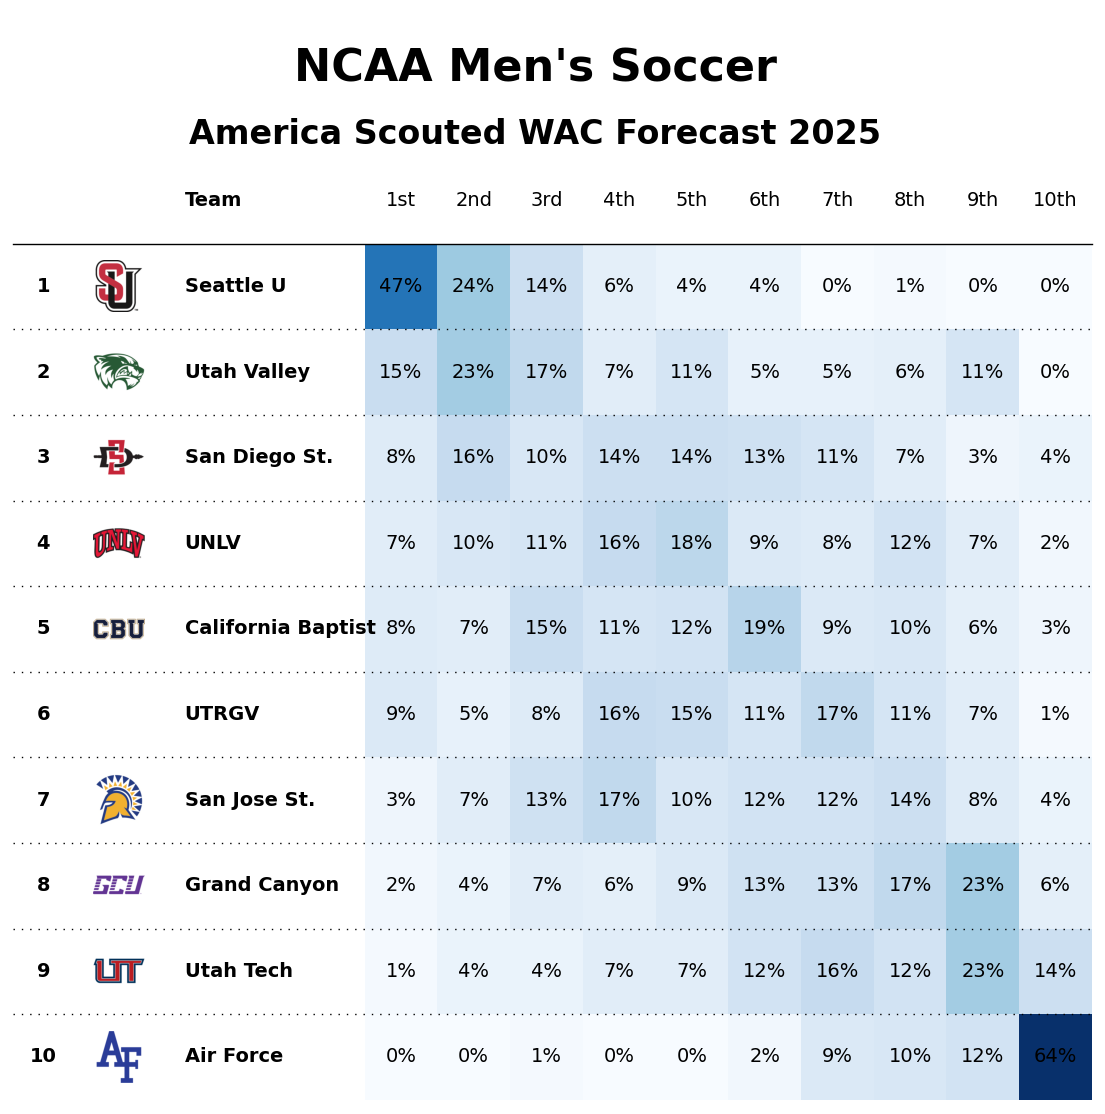

In [41]:
from plottable import ColumnDefinition, Table
from plottable.plots import image
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize

# -----------------------------
# STEP 0: Copy and turn the index into a "Team" column
# -----------------------------
df = rank_df.copy().reset_index().rename(columns={'index': 'Team'})

# -----------------------------
# STEP 1: Add logo paths
# -----------------------------
df["Badge"] = df["Team"].apply(
    lambda x: f"C:/Users/maxwe/OneDrive - The Pennsylvania State University/Statlink/Logos_png/{x}.png"
)

# -----------------------------
# STEP 2: Calculate average finish
# -----------------------------
ordinal_cols = [c for c in df.columns if c.endswith(('st','nd','rd','th'))]

def extract_ordinal_number(col):
    return int(col.rstrip('stndrh'))

weights = [extract_ordinal_number(c) for c in ordinal_cols]

df['AverageFinish'] = df[ordinal_cols].multiply(weights).sum(axis=1) / 100
df = df.sort_values("AverageFinish").drop(columns="AverageFinish").reset_index(drop=True)
df['Rank'] = df.index + 1
df = df.set_index("Rank")
df = df[['Badge','Team'] + ordinal_cols]


# -----------------------------
# STEP 3: Helpers for coloring & formatting
# -----------------------------
# percentage formatter
def pct(v):
    return f"{int(round(v))}%"

# build a linear mapping from [0, vmax] → Blues[0..1]
def linear_cmap(values, cmap, vmin, vmax):
    norm = Normalize(vmin=vmin, vmax=vmax)
    return lambda x: cmap(norm(x))

# compute one common maximum across all ordinal columns
global_max = df[ordinal_cols].to_numpy().max()

# -----------------------------
# STEP 4: Build ColumnDefinitions
# -----------------------------
col_defs = [
    ColumnDefinition(
        name="Rank", title="", textprops={"ha":"center","weight":"bold"}, width=0.5
    ),
    ColumnDefinition(
        name="Badge", title="", width=0.75, plot_fn=image
    ),
    ColumnDefinition(
        name="Team", title="Team", textprops={"ha":"left","weight":"bold"}, width=1.65
    ),
]

for pos in ordinal_cols:
    col_defs.append(
        ColumnDefinition(
            name=pos,
            title=pos,
            width=0.6,
            textprops={"ha":"center"},
            cmap=linear_cmap(df[pos], matplotlib.cm.Blues, vmin=0, vmax=global_max),
            formatter=pct,
        )
    )

# -----------------------------
# STEP 5: Plot function
# -----------------------------
def plot_finish_table(
    df,
    title="NCAA Men's Soccer",        # <-- main title
    subtitle="America Scouted WAC Forecast 2025",  # <-- subtitle
    filename="Forecasts/WAC_table.png"
):
    # create the figure + axes
    fig, ax = plt.subplots(figsize=(14, 12))

    # add the main title and subtitle
    fig.suptitle(title,
                 fontsize=32,
                 fontweight="bold",
                 y=0.99)                   # push up near top
    fig.text(0.5,
             0.91,
             subtitle,
             ha="center",
             fontweight="bold",
             fontsize=24,
             color="black")
    fig.text(0.5,
             1,
             "lol",
             ha="center",
             fontweight="bold",
             fontsize=24,
             color="white")

    # adjust the top margin so titles don't overlap table
    fig.subplots_adjust(top=0.90)

    # draw the table
    Table(
        df,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=False,
        ax=ax,
        textprops={"fontsize":14,"ha":"center","color":"black"},
        row_divider_kw={"linewidth":1,"linestyle":(0,(1,5))},
        col_label_divider_kw={"linewidth":1,"linestyle":"-"},
        column_border_kw={"linewidth":1,"linestyle":"-"},
    )

    # save or show
    #plt.savefig(filename, bbox_inches='tight', dpi=600)
    plt.show()

# -----------------------------
# STEP 6: Run it
# -----------------------------
plot_finish_table(df)

🏆 Creating animation for Atlantic 10
📊 Simulating all 14 teams, showing top 5 each frame
📋 All teams: George Washington, St. Bonaventure, Dayton, Duquesne, Rhode Island, Saint Joseph's, Saint Louis, VCU, La Salle, George Mason, Fordham, Massachusetts, Davidson, Loyola Chicago
Creating animation with team badges...
Saving as GIF...
Saving as GIF...
✅ GIF saved as 'Atlantic_10_Reels.gif'
📱 Ready for Instagram Reels!
✅ GIF saved as 'Atlantic_10_Reels.gif'
📱 Ready for Instagram Reels!


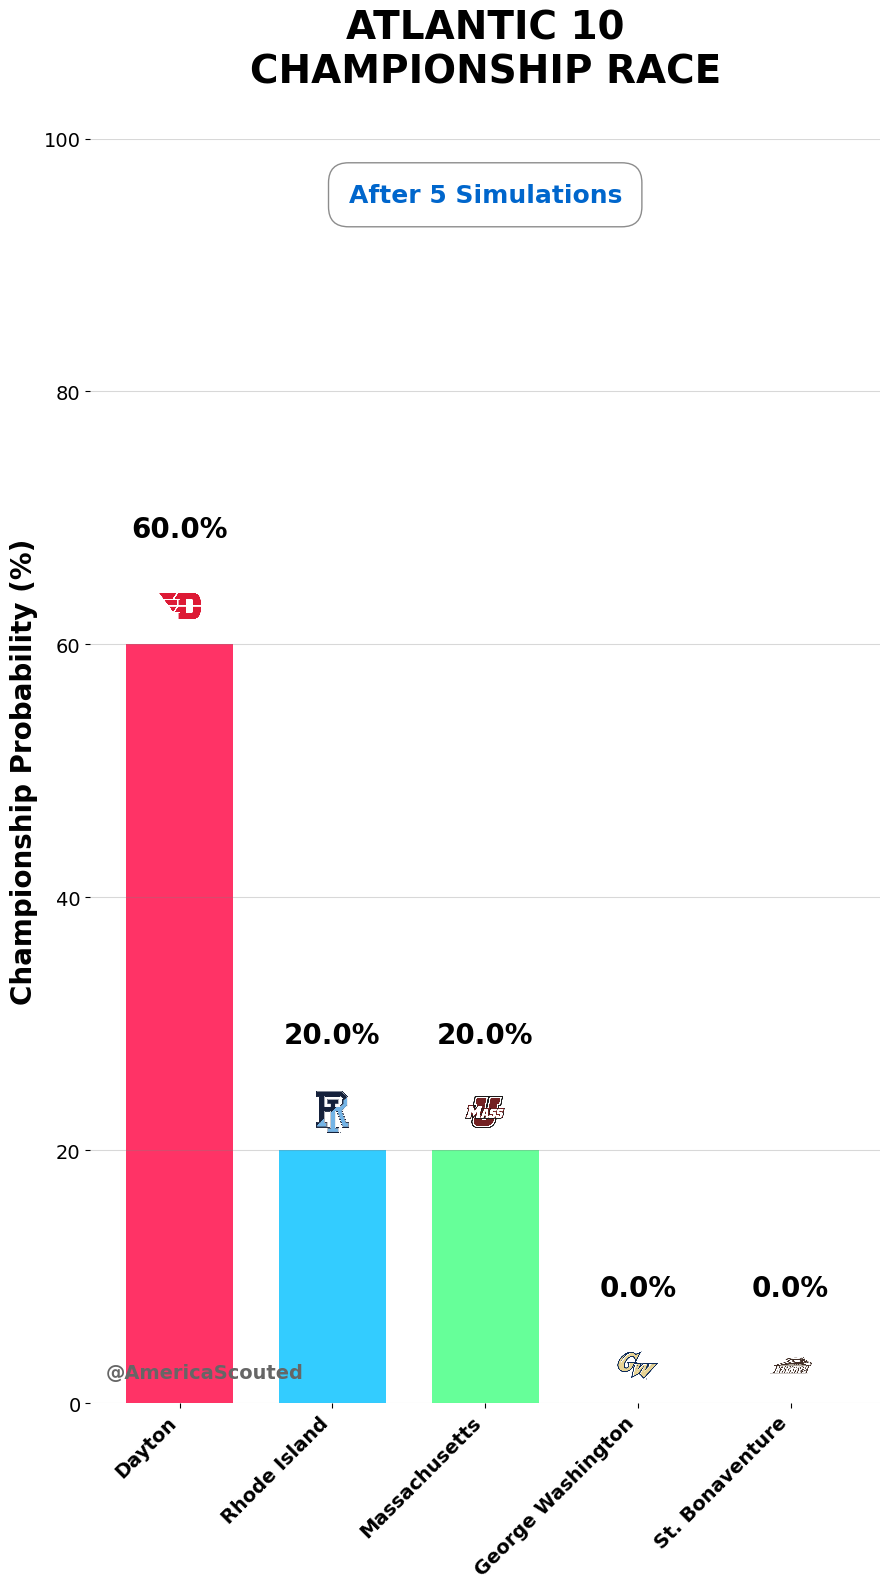

In [ ]:
# Flexible Conference Animation Creator
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
import numpy as np
import random
from collections import defaultdict
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def create_conference_animation(conference_name="Atlantic 10", num_teams=5, output_format="gif"):
    """
    Create championship race animation for any conference
    
    Parameters:
    conference_name (str): Name of the conference (e.g., "Atlantic 10", "Big East", "ACC")
    num_teams (int): Number of top teams to include (default: 5)
    output_format (str): "gif" or "frames" for output type
    """
    
    # Get ALL teams from specified conference
    available_teams = overall_df[overall_df['Conference'] == conference_name]
    if available_teams.empty:
        print(f"❌ No teams found for conference: {conference_name}")
        print("Available conferences:")
        print(overall_df['Conference'].unique())
        return None
    
    # Get ALL teams in the conference for simulation
    teams = available_teams['Team'].tolist()
    print(f"🏆 Creating animation for {conference_name}")
    print(f"📊 Simulating all {len(teams)} teams, showing top {num_teams} each frame")
    print(f"📋 All teams: {', '.join(teams)}")
    
    # Simulate championship probabilities over time
    snapshots = []
    current_wins = {team: 0 for team in teams}  # Track wins for ALL teams
    
    print("Creating animation with team badges...")
    
    # Run simulations and capture snapshots using advanced tournament simulation
    for sim in range(500):
        sim_results = defaultdict(int)
        
        # Create all possible matchups for this simulation (ALL teams)
        matchups = []
        for i in range(len(teams)):
            for j in range(i+1, len(teams)):
                matchups.append((teams[i], teams[j]))
        
        # Randomize home/away for each matchup in this simulation
        for team1, team2 in matchups:
            # Randomly decide who plays at home
            if random.random() < 0.5:
                home_team, away_team = team1, team2
            else:
                home_team, away_team = team2, team1
                
            probs = calculateMatchProbability(home_team, away_team, max_goals=8)
            outcome = random.choices(
                population=['home', 'draw', 'away'],
                weights=[probs['Home Win Probability'], probs['Draw Probability'], probs['Away Win Probability']]
            )[0]
            
            if outcome == 'home':
                sim_results[home_team] += 3
            elif outcome == 'away':
                sim_results[away_team] += 3
            else:
                sim_results[home_team] += 1
                sim_results[away_team] += 1
        
        # Determine tournament winner (team with most points)
        sorted_teams_sim = sorted(sim_results.items(), key=lambda x: x[1], reverse=True)
        winner = sorted_teams_sim[0][0]  # Team with highest points wins tournament
        current_wins[winner] += 1
        
        # Save snapshot every 5 simulations for smoother animation
        if (sim + 1) % 5 == 0:
            # Calculate percentages for ALL teams
            all_percentages = [(team, (current_wins[team] / (sim + 1)) * 100) for team in teams]
            all_percentages.sort(key=lambda x: x[1], reverse=True)
            
            # Only keep top NUM_TEAMS for display
            top_percentages = all_percentages[:num_teams]
            
            snapshots.append({
                'simulation': sim + 1,
                'data': top_percentages  # Only store top teams for animation
            })
    
    # Create the animation - Reels format (9:16 aspect ratio)
    fig, ax = plt.subplots(figsize=(9, 16))
    fig.patch.set_facecolor('#ffffff')  # White background for Reels
    
    # Add more white space around the plot
    plt.subplots_adjust(left=0.15, right=0.85, top=0.92, bottom=0.12)
    
    def load_team_badge(team_name):
        """Load team badge image and remove white background"""
        try:
            badge_path = f"C:/Users/maxwe/OneDrive - The Pennsylvania State University/Statlink/Logos_png/{team_name}.png"
            img = mpimg.imread(badge_path)
            
            # If image has 4 channels (RGBA), return as is
            if img.shape[2] == 4:
                return img
            
            # If image has 3 channels (RGB), add alpha channel and make white transparent
            if img.shape[2] == 3:
                # Create RGBA version
                rgba_img = np.zeros((img.shape[0], img.shape[1], 4))
                rgba_img[:, :, :3] = img  # Copy RGB channels
                
                # Set alpha channel to 0 (transparent) where pixels are white or near-white
                white_mask = np.all(img > 0.9, axis=2)
                rgba_img[:, :, 3] = np.where(white_mask, 0, 1)  # 0 = transparent, 1 = opaque
                
                return rgba_img
                
            return img
        except:
            # Return None if badge not found
            return None
    
    def animate_frame(frame_num):
        ax.clear()
        ax.set_facecolor('#ffffff')
        
        # Get data for this frame
        snapshot = snapshots[frame_num]
        team_data = snapshot['data']
        sim_count = snapshot['simulation']
        
        # Extract teams and percentages
        team_names = [item[0] for item in team_data]
        percentages = [item[1] for item in team_data]
        
        # Create vertical bars (perfect for Reels)
        x_positions = np.arange(len(team_names))
        colors = ['#ff3366', '#33ccff', '#66ff99', '#ffcc33', '#cc66ff', '#ff9933', '#9933ff'][:len(team_names)]
        
        bars = ax.bar(x_positions, percentages, color=colors, width=0.7)
        
        # Add team badges above bars
        for i, (team, pct) in enumerate(zip(team_names, percentages)):
            badge_img = load_team_badge(team)
            if badge_img is not None:
                # Position badge above the bar
                badge_y = pct + 3
                imagebox = OffsetImage(badge_img, zoom=0.15)
                ab = AnnotationBbox(imagebox, (i, badge_y), frameon=False)
                ax.add_artist(ab)
            
            # Add percentage labels below badges
            ax.text(i, pct + 8, f'{pct:.1f}%', 
                   ha='center', va='bottom', 
                   color='black', fontweight='bold', fontsize=20)
        
        # Styling for Reels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(team_names, fontsize=16, color='black', fontweight='bold', rotation=45, ha='right')
        ax.set_ylabel('Championship Probability (%)', fontsize=20, color='black', fontweight='bold')
        
        # Dynamic title based on conference
        conference_display = conference_name.upper().replace(" ", " ")
        ax.set_title(f'{conference_display}\nCHAMPIONSHIP RACE', 
                    fontsize=28, color='black', fontweight='bold', pad=40)
        
        # Set limits with padding for badges and more white space
        ax.set_ylim(0, max(100, max(percentages) * 1.5))
        ax.set_xlim(-0.6, len(team_names) - 0.4)
        
        # Grid and styling
        ax.grid(axis='y', alpha=0.3, color='gray')
        ax.set_facecolor('#ffffff')
        
        # Add extra white space around the content
        ax.margins(x=0.1, y=0.1)
        
        # Large simulation counter for mobile
        ax.text(0.5, 0.95, f'After {sim_count} Simulations', 
               transform=ax.transAxes, 
               fontsize=18, color='#0066cc', fontweight='bold', ha='center',
               bbox=dict(boxstyle='round,pad=0.8', facecolor='white', edgecolor='gray', alpha=0.9))
        
        # Add watermark
        ax.text(0.02, 0.02, '@AmericaScouted', 
               transform=ax.transAxes, 
               fontsize=14, color='#666666', fontweight='bold')
        
        # Remove spines for cleaner look
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Black text for labels
        ax.tick_params(colors='black', labelsize=14)
        
        # Use tight_layout with more padding
        plt.tight_layout(pad=3.0)
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate_frame, frames=len(snapshots), 
                                 interval=100, repeat=True, blit=False)
    
    # Clean conference name for filename
    clean_conference = conference_name.replace(" ", "_").replace("&", "and")
    
    if output_format.lower() == "gif":
        # Save as GIF
        print("Saving as GIF...")
        writer = animation.PillowWriter(fps=10, metadata={'title': f'{conference_name} Championship Race'})
        filename = f'{clean_conference}_Reels.gif'
        anim.save(filename, writer=writer, dpi=100, 
                  savefig_kwargs={'facecolor': 'white'})
        print(f"✅ GIF saved as '{filename}'")
        
    elif output_format.lower() == "frames":
        # Save as individual frames
        print("Saving as individual frames...")
        frame_dir = f"{clean_conference}_frames"
        import os
        if not os.path.exists(frame_dir):
            os.makedirs(frame_dir)
        
        for i, frame in enumerate(range(len(snapshots))):
            animate_frame(frame)
            plt.savefig(f"{frame_dir}/frame_{i:04d}.png", 
                       facecolor='white', dpi=100, bbox_inches='tight')
        
        plt.close(fig)
        print(f"✅ Saved {len(snapshots)} frames in '{frame_dir}' folder")
        print("🎯 Use online converter to create MP4 at 10fps")
    
    print("📱 Ready for Instagram Reels!")
    return anim

# ========================================
# CHANGE THESE VARIABLES TO CREATE DIFFERENT ANIMATIONS
# ========================================

CONFERENCE = "Atlantic 10"  # Change this to any conference name
NUM_TEAMS = 5              # Change this to show more/fewer teams
OUTPUT = "gif"             # Change to "frames" for MP4 conversion

# Create the animation
animation_result = create_conference_animation(
    conference_name=CONFERENCE,
    num_teams=NUM_TEAMS,
    output_format=OUTPUT
)